In [2]:
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

from preprocessing import get_df

In [3]:
def add_features(dataframe: pd.DataFrame):
    sia = SentimentIntensityAnalyzer()

    stopwords_english = stopwords.words('english')
    vectorizer = TfidfVectorizer(stop_words=stopwords_english)
    analyzer = vectorizer.build_analyzer()

    def calculate_number_of_stopwords(text):
        return 1 - len(analyzer(text)) / len(text.split())

    # соотношение количества знаков пунктуации к длине текста
    def calculate_number_of_punctuation(text):
        number_of_punctuation = len(re.findall(r'[^\w\s]', text))
        return number_of_punctuation / len(text)

    def calculate_sentiment(text):
        return sia.polarity_scores(text)['compound']

    dataframe = dataframe.copy(deep=True)
    dataframe['number_of_stopwords'] = dataframe['text'].apply(calculate_number_of_stopwords)
    dataframe['number_of_punctuation'] = dataframe['text'].apply(calculate_number_of_punctuation)
    dataframe['sentiment'] = dataframe['text'].apply(calculate_sentiment)

    return dataframe

def plot_confusion_matrix(prediction, target):
    cm = confusion_matrix(target, prediction)
    f, ax = plt.subplots(figsize =(5,5))
    sns.heatmap(cm,annot = True, linewidths=0.5, linecolor="red", fmt = ".0f", ax=ax)
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

def split_dataset_train_model_estimate_accuracy(data, target):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2, random_state=42)

    for modelClass, name in zip(
        [SVC, DecisionTreeClassifier, LogisticRegression],
        ['SVC', 'DecisionTreeClassifier', 'LogisticRegression']
    ):
        model = modelClass()
        model.fit(train_x, train_y)
        prediction = model.predict(test_x)

        print(
            name,
            'accuracy:', accuracy_score(test_y, prediction),
            'precision:', precision_score(test_y, prediction),
            'recall:', recall_score(test_y, prediction)
        )

        # строим график только для SVC модели, так как точность у моделей примерно одинаковая
        if name == 'SVC':
            # для примера строим confusion matrix
            plot_confusion_matrix(prediction, test_y)

In [4]:
def test_models_without_additional_features():
    df = get_df()

    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
    vectors = vectorizer.fit_transform(df['text'])

    data = vectors.toarray()
    target = df['category']

    split_dataset_train_model_estimate_accuracy(data, target)

SVC accuracy: 0.9739910313901345 precision: 1.0 recall: 0.8066666666666666


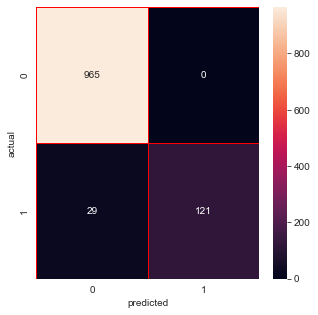

DecisionTreeClassifier accuracy: 0.967713004484305 precision: 0.8958333333333334 recall: 0.86
LogisticRegression accuracy: 0.9533632286995516 precision: 0.99 recall: 0.66


In [5]:
test_models_without_additional_features()

In [6]:
def test_models_with_additional_features():
    df = get_df()
    df = add_features(df)

    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
    vectors = vectorizer.fit_transform(df['text'])

    additional_data = scale(df[['number_of_stopwords', 'number_of_punctuation', 'sentiment']].values)
    data = np.append(additional_data, vectors.toarray(), axis=1)
    target = df['category']

    split_dataset_train_model_estimate_accuracy(data, target)

SVC accuracy: 0.967713004484305 precision: 0.9913793103448276 recall: 0.7666666666666667


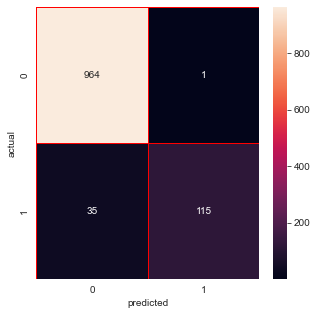

DecisionTreeClassifier accuracy: 0.9623318385650225 precision: 0.8648648648648649 recall: 0.8533333333333334
LogisticRegression accuracy: 0.95695067264574 precision: 0.9903846153846154 recall: 0.6866666666666666


In [7]:
test_models_with_additional_features()

Разница в пределах статистической погрешности, возможные причины:
1. слишком мало данных
2. некорректные модели для подобных данных
3. некорректно сформированы признаки
4. сформированных векторов и так полностью достаточно для определения категории

Также нужно отметить, что в данных присутствует дисбаланс (ham гораздо больше, чем spam)

In [8]:
def test_models_with_only_additional_features():
    df = get_df()
    df = add_features(df)

    additional_data = scale(df[['number_of_stopwords', 'number_of_punctuation', 'sentiment']].values)
    data = additional_data
    target = df['category']

    split_dataset_train_model_estimate_accuracy(data, target)

SVC accuracy: 0.8780269058295964 precision: 0.6166666666666667 recall: 0.24666666666666667


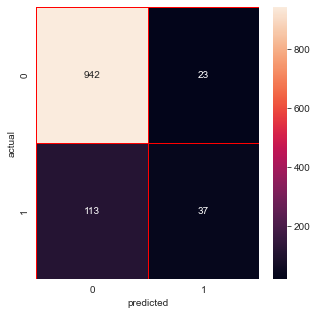

DecisionTreeClassifier accuracy: 0.885201793721973 precision: 0.5797101449275363 recall: 0.5333333333333333
LogisticRegression accuracy: 0.8609865470852018 precision: 0.2222222222222222 recall: 0.013333333333333334


In [9]:
test_models_with_only_additional_features()

Судя по recall/precision, модель просто определяет все как ham, что дает высокую точность, так как ham в датасете гораздо больше, чем spam. Если бы они были сбалансированы, то точность не превышала бы 50-55 процентов
